# Dissecting the Schreiber-Karplus HMM for Epigenetic Classification

This notebook builds understanding of the model from the ground up through code.

## Part 1: Understanding the Input Data

Before we look at the model, let's understand what it operates on.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load one data file
with open('Data/14418004-s04.json', 'r') as f:
    data = json.load(f)

print "File contains {} events".format(len(data['events']))

# Look at one event
event = data['events'][0]
print "\nFirst event has {} segments".format(len(event['segments']))

# Look at one segment
seg = event['segments'][0]
print "\nFirst segment:"
for key, val in seg.items():
    print "  {}: {}".format(key, val)

File contains 47 events

First event has 88 segments

First segment:
  std: 9.66011225953
  end: 0.001
  name: Segment
  min: 41.2768194352
  max: 88.5419531099
  start: 0.0
  duration: 0.001
  mean: 45.9977140879


HMM input: sequence of 88 current levels (pA)
First 10 values: [45.997714087929154, 41.23041537224768, 39.04334263211996, 41.08959465028295, 41.33028816496282, 36.231545181472484, 36.679059711350774, 36.26825057895933, 35.758334815598836, 36.155634764936025]


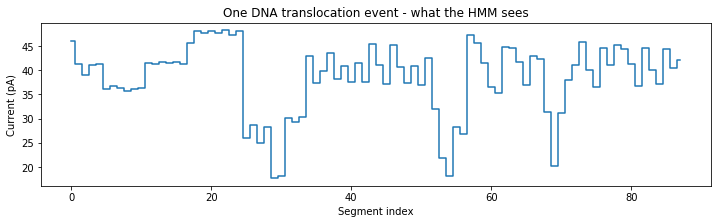

In [2]:
# What the HMM actually sees: just the MEANS
event_means = [seg['mean'] for seg in event['segments']]

print "HMM input: sequence of {} current levels (pA)".format(len(event_means))
print "First 10 values:", event_means[:10]

# Visualize one event
plt.figure(figsize=(12, 3))
plt.step(range(len(event_means)), event_means, where='mid')
plt.xlabel('Segment index')
plt.ylabel('Current (pA)')
plt.title('One DNA translocation event - what the HMM sees')
plt.show()

## Part 2: The Building Block - HMMBoard

The key innovation is the **modular circuit board** architecture. Each position in the DNA sequence is represented by a "board" with ports on each side.

```
   s1 ─────────────────────── e1   (Port 1: Delete path)
   s2 ────[STATES]──────────── e2   (Port 2: Match path - main)
   s3 ─────────────────────── e3   (Port 3)
   s4 ─────────────────────── e4   (Undersegmentation entry)
   s5 ─────────────────────── e5   (Backslip)
   s6 ─────────────────────── e6   (Flicker start)
   s7 ─────────────────────── e7   (Flicker end)
```

In [3]:
from yahmm import Model, State, NormalDistribution, UniformDistribution

# Let's recreate a simplified HMMBoard to understand it
class SimpleBoard(Model):
    """A HMM circuit board with n ports on each side."""
    
    def __init__(self, n, name):
        super(SimpleBoard, self).__init__(name="Board {}".format(name))
        self.n = n
        
        # Create n start ports and n end ports (all silent states)
        for i in xrange(1, n+1):
            start = State(None, name="b{}s{}".format(name, i))  # Silent state
            end = State(None, name="b{}e{}".format(name, i))    # Silent state
            
            # Store as attributes: self.s1, self.s2, ..., self.e1, self.e2, ...
            setattr(self, "s{}".format(i), start)
            setattr(self, "e{}".format(i), end)
            
            self.add_state(start)
            self.add_state(end)

# Create a simple 3-port board
board = SimpleBoard(n=3, name="test")
print "Created board with {} ports".format(board.n)
print "Start ports: s1={}, s2={}, s3={}".format(board.s1.name, board.s2.name, board.s3.name)
print "End ports: e1={}, e2={}, e3={}".format(board.e1.name, board.e2.name, board.e3.name)

Created board with 3 ports
Start ports: s1=btests1, s2=btests2, s3=btests3
End ports: e1=bteste1, e2=bteste2, e3=bteste3


In [6]:
board.

<function dense_transition_matrix>

## Part 3: A Single Module - Handling Nanopore Artifacts

Each module handles multiple error types:
- **Match (M)**: Normal reading of one base
- **Match-Overseg (MO)**: Signal was incorrectly split into multiple segments
- **Delete (D)**: Base was skipped entirely
- **Insert (I)**: Extra noise/blips between bases
- **Backslip**: Enzyme went backwards

Let's build one module step by step.

In [10]:
from PyPore.hmm import HMMBoard

def build_match_submodel(distribution, name):
    """
    The match state is actually a mini-HMM to handle oversegmentation.
    
    start ─┬─ 0.95 ──> M  (normal match, 10% self-loop, 90% exit)
           │
           └─ 0.05 ──> MO (overseg match, 80% self-loop, 20% exit)
    
    Why? If the signal for one base gets split into 2-3 segments,
    MO's high self-loop probability (80%) explains seeing the same
    current level multiple times.
    """
    model = Model(name=name)
    
    # Both states emit from the SAME distribution (same expected current)
    match = State(distribution, name="M-{}".format(name))
    match_os = State(distribution, name="MO-{}".format(name))  # OS = oversegmentation
    
    model.add_state(match)
    model.add_state(match_os)
    
    # Entry transitions
    model.add_transition(model.start, match, 0.95)     # Usually no overseg
    model.add_transition(model.start, match_os, 0.05) # Sometimes overseg
    
    # Match state: rarely self-loops (normal case)
    model.add_transition(match, match, 0.10)
    model.add_transition(match, model.end, 0.90)
    
    # Overseg state: often self-loops (absorbs extra segments)
    model.add_transition(match_os, match_os, 0.80)
    model.add_transition(match_os, model.end, 0.20)
    
    return model

# Example: expected current for one base position is 50 pA with std 5
dist = NormalDistribution(50, 5)
dist

NormalDistribution(50, 5)

In [8]:
match_model = build_match_submodel(dist, "pos1")

In [9]:
match_model.states

In [33]:
def build_full_module(distribution, position, low=0, high=90):
    """
    Build a complete 7-port module for one DNA position.
    
    This handles:
    - Matches (with oversegmentation)
    - Deletes (skipped bases)
    - Inserts (noise/blips)
    - Backslips (backward movement)
    - Flicker (repeated attempts)
    """
    board = HMMBoard(n=7, name=str(position))
    
    # Create the states
    delete = State(None, name="D-{}".format(position))  # Silent - skips this base
    match = build_match_submodel(distribution, "M-{}".format(position))
    insert = State(UniformDistribution(low, high), name="I-{}".format(position))  # Noise
    match_s = State(distribution, name="MS-{}".format(position))  # Flicker start
    match_e = State(distribution, name="ME-{}".format(position))  # Flicker end
    
    # Add to board
    board.add_model(match)
    for state in [delete, insert, match_s, match_e]:
        board.add_state(state)
    
    # === PORT CONNECTIONS ===
    # Port 1: Delete path
    board.add_transition(board.s1, delete, 1.00)
    
    # Port 2: Main match path  
    board.add_transition(board.s2, match.start, 1.00)
    
    # Port 3-4: Undersegmentation handling (connects to U-module between positions)
    board.add_transition(board.s3, board.e4, 1.00)
    board.add_transition(board.s4, match.end, 1.00)
    
    # Port 5: Connects to match for flicker
    board.add_transition(board.e5, match_e, 1.00)
    
    # Port 6-7: Flicker handling (backward path)
    board.add_transition(board.s6, match_s, 1.00)
    board.add_transition(board.e7, match.start, 0.90)
    board.add_transition(board.e7, match_e, 0.05)
    board.add_transition(board.e7, board.s7, 0.05)
    
    # === DELETE STATE TRANSITIONS ===
    board.add_transition(delete, board.e1, 0.1)   # Stay on delete path
    board.add_transition(delete, insert, 0.1)    # Delete + insert noise
    board.add_transition(delete, board.e2, 0.8)  # Rejoin main path
    
    # === INSERT STATE TRANSITIONS ===
    board.add_transition(insert, match.start, 0.10)  # Insert then match
    board.add_transition(insert, insert, 0.50)       # Multiple inserts
    board.add_transition(insert, board.e1, 0.05)
    board.add_transition(insert, board.e2, 0.35)
    
    # === MATCH END TRANSITIONS ===
    board.add_transition(match.end, insert, 0.01)
    board.add_transition(match.end, board.e1, 0.01)
    board.add_transition(match.end, board.e2, 0.96)  # Usually go forward
    board.add_transition(match.end, board.e3, 0.01)  # Underseg path
    board.add_transition(match.end, board.s7, 0.01)  # Backslip!
    
    # === FLICKER TRANSITIONS ===
    board.add_transition(match_s, board.s5, 0.80)
    board.add_transition(match_s, match_s, 0.20)  # Self-loop
    
    board.add_transition(match_e, board.e2, 0.10)
    board.add_transition(match_e, match_e, 0.10)
    board.add_transition(match_e, board.e6, 0.80)
    
    return board

# Build one module
module = build_full_module(NormalDistribution(50, 5), position=1)

# IMPORTANT: In yahmm, .states is None until you call .bake()
# Before baking, states are stored in the graph
all_states = list(module.graph.nodes())
print "Module has {} states (from graph, before baking)".format(len(all_states))

# Count state types
silent = sum(1 for s in all_states if s.distribution is None)
emitting = len(all_states) - silent
print "  Silent states (ports, delete, start/end): {}".format(silent)
print "  Emitting states (match, insert, flicker): {}".format(emitting)

# Show state names
print "\nAll states:"
for s in sorted(all_states, key=lambda x: x.name):
    emit_type = type(s.distribution).__name__ if s.distribution else "Silent"
    print "  {} -> {}".format(s.name, emit_type)

Module has 24 states (from graph, before baking)
  Silent states (ports, delete, start/end): 19
  Emitting states (match, insert, flicker): 5

All states:
  Board 1-end -> Silent
  Board 1-start -> Silent
  D-1 -> Silent
  I-1 -> UniformDistribution
  M-1-end -> Silent
  M-1-start -> Silent
  M-M-1 -> NormalDistribution
  ME-1 -> NormalDistribution
  MO-M-1 -> NormalDistribution
  MS-1 -> NormalDistribution
  b1e1 -> Silent
  b1e2 -> Silent
  b1e3 -> Silent
  b1e4 -> Silent
  b1e5 -> Silent
  b1e6 -> Silent
  b1e7 -> Silent
  b1s1 -> Silent
  b1s2 -> Silent
  b1s3 -> Silent
  b1s4 -> Silent
  b1s5 -> Silent
  b1s6 -> Silent
  b1s7 -> Silent


In [44]:
# ============================================================
# PIECE BY PIECE: Understanding the HMM Building Syntax
# ============================================================

# === PIECE 1: The Board (Container) ===
# HMMBoard creates a container with n "ports" on each side
# Think of it like a circuit board with connectors

demo_board = HMMBoard(n=3, name="demo")

print "PIECE 1: HMMBoard(n=3, name='demo')"
print "  Creates a Model (HMM) that inherits from yahmm.Model"
print "  Automatically creates {} port pairs:".format(demo_board.n)
print "    - demo_board.s1, demo_board.s2, demo_board.s3  (start ports)"
print "    - demo_board.e1, demo_board.e2, demo_board.e3  (end ports)"
print "  These are SILENT states (no emission) - just connection points"
print ""
print "  Actual objects:"
print "    demo_board.s1 =", demo_board.s1
print "    demo_board.e1 =", demo_board.e1

PIECE 1: HMMBoard(n=3, name='demo')
  Creates a Model (HMM) that inherits from yahmm.Model
  Automatically creates 3 port pairs:
    - demo_board.s1, demo_board.s2, demo_board.s3  (start ports)
    - demo_board.e1, demo_board.e2, demo_board.e3  (end ports)
  These are SILENT states (no emission) - just connection points

  Actual objects:
    demo_board.s1 = State( None, name=bdemos1, weight=1.0, identity=139723407514352 )
    demo_board.e1 = State( None, name=bdemoe1, weight=1.0, identity=139723407513232 )


In [45]:
# === PIECE 2: States (The Nodes) ===
# A State is a node in the HMM graph
# It has: a name, and optionally an emission distribution

print "PIECE 2: State(distribution, name='...')"
print ""

# Silent state - no emission (distribution=None)
silent_state = State(None, name="MySilentState")
print "Silent state: State(None, name='MySilentState')"
print "  silent_state.distribution =", silent_state.distribution
print "  This state does NOT emit observations - just routing"
print ""

# Emitting state - has a distribution
emitting_state = State(NormalDistribution(50, 5), name="MyEmittingState")
print "Emitting state: State(NormalDistribution(50, 5), name='MyEmittingState')"
print "  emitting_state.distribution =", emitting_state.distribution
print "  When HMM is in this state, it 'expects' to see ~50 pA (with std 5)"
print ""

# The distribution can compute probability of observations
obs = 48.0
log_prob = emitting_state.distribution.log_probability(obs)
print "  P(observing {} pA | this state) = exp({:.3f}) = {:.6f}".format(
    obs, log_prob, np.exp(log_prob))

PIECE 2: State(distribution, name='...')

Silent state: State(None, name='MySilentState')
  silent_state.distribution = None
  This state does NOT emit observations - just routing

Emitting state: State(NormalDistribution(50, 5), name='MyEmittingState')
  emitting_state.distribution = NormalDistribution(50, 5)
  When HMM is in this state, it 'expects' to see ~50 pA (with std 5)

  P(observing 48.0 pA | this state) = exp(-2.608) = 0.073654


In [46]:
# === PIECE 3: Adding States to the Board ===
# States must be added to the model before you can connect them

print "PIECE 3: board.add_state(state) and board.add_model(submodel)"
print ""

# Create a fresh board
board = HMMBoard(n=2, name="example")

# Create some states
state_a = State(NormalDistribution(40, 3), name="A")
state_b = State(NormalDistribution(60, 3), name="B")

# Add them to the board
board.add_state(state_a)
board.add_state(state_b)

print "After board.add_state(state_a) and board.add_state(state_b):"
print "  States in graph:", [s.name for s in board.graph.nodes()]
print ""

# You can also add an entire sub-model (like the match model)
# This copies all states from the sub-model into the board
sub_model = Model("SubModel")
sub_state_1 = State(NormalDistribution(55, 2), name="Sub1")
sub_state_2 = State(NormalDistribution(55, 2), name="Sub2")
sub_model.add_state(sub_state_1)
sub_model.add_state(sub_state_2)

board.add_model(sub_model)

print "After board.add_model(sub_model):"
print "  States in graph:", [s.name for s in board.graph.nodes()]
print ""
print "  Note: sub_model has .start and .end states that are added too!"
print "  These let you connect TO and FROM the sub-model"

PIECE 3: board.add_state(state) and board.add_model(submodel)

After board.add_state(state_a) and board.add_state(state_b):
  States in graph: ['Board example-start', 'B', 'bexamplee2', 'bexamplee1', 'A', 'Board example-end', 'bexamples1', 'bexamples2']

After board.add_model(sub_model):
  States in graph: ['Sub2', 'Board example-start', 'B', 'SubModel-end', 'bexamplee2', 'SubModel-start', 'bexamplee1', 'A', 'Board example-end', 'bexamples1', 'Sub1', 'bexamples2']

  Note: sub_model has .start and .end states that are added too!
  These let you connect TO and FROM the sub-model


In [ ]:
# === PIECE 4: Transitions (The Edges) ===
# Transitions connect states and define movement probabilities

print "PIECE 4: board.add_transition(from_state, to_state, probability)"
print ""

# Create a simple example
board = HMMBoard(n=2, name="trans_demo")
match = State(NormalDistribution(50, 5), name="Match")
insert = State(UniformDistribution(0, 90), name="Insert")
board.add_state(match)
board.add_state(insert)

# Add transitions
board.add_transition(board.s1, match, 0.90)   # 90% chance: port s1 -> match
board.add_transition(board.s1, insert, 0.10)  # 10% chance: port s1 -> insert
board.add_transition(match, board.e1, 0.80)   # 80% chance: match -> exit
board.add_transition(match, match, 0.20)      # 20% chance: match -> match (self-loop!)
board.add_transition(insert, match, 0.50)     # 50% chance: insert -> match
board.add_transition(insert, insert, 0.50)    # 50% chance: insert -> insert (self-loop)

# Let's see what keys are actually in the edge data
print "First, let's see what yahmm stores in edge data:"
for src, dst, data in list(board.graph.edges(data=True))[:1]:
    print "  Edge data keys:", data.keys()
    print "  Full data:", data
print ""

# The probability is stored under 'weight' in yahmm!
print "Transitions added:"
for src, dst, data in board.graph.edges(data=True):
    prob = data.get('weight', '?')  # yahmm uses 'weight', not 'probability'
    print "  {} -> {} (p={})".format(src.name, dst.name, prob)

print ""
print "KEY INSIGHT: Probabilities from one state must sum to 1.0"
print "  From Match: 0.80 + 0.20 = 1.0  (check)"
print "  From Insert: 0.50 + 0.50 = 1.0  (check)"
print ""
print "SELF-LOOPS are powerful!"
print "  match -> match (0.20) means: 'stay here and emit another observation'"
print "  This explains seeing MULTIPLE segments at the same current level"

## Summary: The 4 Pieces of HMM Construction

| Piece | Syntax | What it does |
|-------|--------|--------------|
| **1. Board** | `HMMBoard(n=7, name="1")` | Creates container with 7 port pairs (s1-s7, e1-e7) |
| **2. States** | `State(distribution, name)` | Creates a node. `None` = silent, else emits |
| **3. Adding** | `board.add_state(s)` / `board.add_model(m)` | Puts states into the graph |
| **4. Transitions** | `board.add_transition(A, B, 0.8)` | Creates edge A→B with probability 0.8 |

### Now re-read the original code with understanding:

```python
board = HMMBoard(n=7, name=str(position))     # PIECE 1: Create 7-port board

delete = State(None, name="D-1")              # PIECE 2: Silent state (skip base)
match = build_match_submodel(...)             # PIECE 2: Sub-HMM with M and MO states
insert = State(UniformDistribution(...))      # PIECE 2: Emitting state (noise)

board.add_model(match)                        # PIECE 3: Add sub-model to board
board.add_state(delete)                       # PIECE 3: Add state to board

board.add_transition(board.s1, delete, 1.0)   # PIECE 4: Port s1 → delete
board.add_transition(board.s2, match.start, 1.0)  # PIECE 4: Port s2 → match entry
board.add_transition(match.end, board.e2, 0.96)   # PIECE 4: match exit → port e2
```

### The Port Convention:
- **s1/e1**: Delete path (skipped bases)
- **s2/e2**: Main match path (normal flow)
- **s3/e3/s4/e4**: Undersegmentation handling
- **s5/e5/s6/e6**: Flicker (repeated attempts)
- **s7/e7**: Backslip (backward movement)

In [ ]:
# Let's break down what each state IS and DOES

print """
=== ANATOMY OF ONE HMM MODULE (Position 1) ===

An HMM has TWO components:
  1. STATES with EMISSIONS (what current level do we expect to see?)
  2. TRANSITIONS between states (what's the probability of moving?)

SILENT STATES (19) - No emission, just routing logic:
─────────────────────────────────────────────────────
  b1s1 - b1s7  : 7 "start ports" - entry points from previous module
  b1e1 - b1e7  : 7 "end ports" - exit points to next module
  
  Board 1-start : The board's global start (yahmm internal)
  Board 1-end   : The board's global end (yahmm internal)
  
  M-1-start     : Entry to the match sub-model
  M-1-end       : Exit from the match sub-model
  
  D-1           : Delete state - skips this base entirely

EMITTING STATES (5) - These actually "see" the data:
─────────────────────────────────────────────────────
  M-M-1   : Match state - emits from NormalDistribution(50, 5)
            "I expect to see ~50 pA at this position"
            
  MO-M-1  : Oversegmentation match - SAME distribution as M-M-1
            But has 80% self-loop (explains seeing 50 pA multiple times)
            
  I-1     : Insert state - emits from UniformDistribution(0, 90)
            "Random noise, could be anything"
            
  MS-1    : Flicker start - emits from NormalDistribution(50, 5)
            Part of backward/repeat handling
            
  ME-1    : Flicker end - emits from NormalDistribution(50, 5)
            Part of backward/repeat handling
"""

# Show the actual emission distributions
print "=== EMISSION DISTRIBUTIONS ==="
for s in sorted(all_states, key=lambda x: x.name):
    if s.distribution is not None:
        dist = s.distribution
        if hasattr(dist, 'parameters'):
            params = dist.parameters
            print "{:12} -> {} with params {}".format(s.name, type(dist).__name__, params)
        else:
            print "{:12} -> {}".format(s.name, type(dist).__name__)

In [ ]:
# Now let's look at TRANSITIONS (stored as edges in the graph)

print "=== TRANSITIONS (edges with probabilities) ===\n"

# Get all edges from the graph
edges = module.graph.edges(data=True)

# Group by source state for clarity
from collections import defaultdict
transitions = defaultdict(list)

for src, dst, data in edges:
    # yahmm stores probability under 'weight' key
    prob = data.get('weight', '?')
    transitions[src.name].append((dst.name, prob))

# Print nicely
for src_name in sorted(transitions.keys()):
    print "FROM: {}".format(src_name)
    for dst_name, prob in sorted(transitions[src_name]):
        print "   -> {} (p={})".format(dst_name, prob)
    print ""

## Visual: How Signals Flow Through One Module

```
                         ┌──────────────────────────────────────────────┐
                         │            ONE DNA POSITION MODULE           │
FROM PREVIOUS MODULE     │                                              │    TO NEXT MODULE
                         │                                              │
    s1 ─────────────────>│──> D-1 (Delete) ──────────────────────────>──│──> e1
         (delete path)   │      │                                       │     (stayed on delete)
                         │      │ 0.8                                   │
                         │      v                                       │
    s2 ─────────────────>│──> [MATCH MODEL] ─────────────────────────>──│──> e2
         (main path)     │    ┌─────────────────┐         0.96          │     (main forward)
                         │    │ start           │                       │
                         │    │   │             │                       │
                         │    │   ├─0.95─> M ───┤ (normal match)        │
                         │    │   │         │   │                       │
                         │    │   └─0.05─> MO ──┤ (overseg match)       │
                         │    │             │   │  80% self-loop!       │
                         │    │           end   │                       │
                         │    └─────────────────┘                       │
                         │            │                                 │
                         │            │ 0.01                            │
                         │            v                                 │
    s3 ──────────────────│────────────────────────────────────────────>─│──> e3
         (underseg in)   │                                              │     (underseg out)
                         │                                              │
    s4 <─────────────────│<──────────────────────────────────────────<──│<── e4
         (underseg ret)  │                                              │     (from U-module)
                         │                                              │
    s5 <─────────────────│<── MS-1 <────────────────────────────────<───│<── e5
         (flicker)       │    (flicker start)                           │     (backslip entry)
                         │                                              │
    s6 ─────────────────>│──> ME-1 ─────────────────────────────────>───│──> e6
         (flicker out)   │    (flicker end)                             │     (flicker exit)
                         │                                              │
    s7 <────── 0.01 ─────│<── [from match.end - BACKSLIP!] ─────────<───│<── e7
         (backslip)      │                                              │     (backslip chain)
                         │                                              │
                         │     I-1 (Insert) - uniform noise             │
                         │       absorbs random blips/spikes            │
                         │                                              │
                         └──────────────────────────────────────────────┘

EMISSION PROBABILITIES:
  When in state M-M-1 and we observe 48 pA:
    P(48 | Normal(50, 5)) = exp(-(48-50)²/(2*5²)) / (5*√(2π)) ≈ 0.074
    
  When in state I-1 and we observe 48 pA:
    P(48 | Uniform(0, 90)) = 1/90 ≈ 0.011
    
  → The match state is more likely! HMM will prefer that path.
```

In [39]:
module.s1.is_silent()

True

## Part 4: Undersegmentation Module

When the segmentation algorithm fails to split two adjacent bases, the HMM sees ONE segment with a current level that's the AVERAGE of the two expected levels.

The U-module creates a "blend" state between adjacent positions.

In [19]:
def build_underseg_module(dist_a, dist_b, name):
    """
    Build an undersegmentation handling module.
    
    When two segments should have been split but weren't,
    we see one segment with mean = (mean_a + mean_b) / 2
    """
    board = HMMBoard(n=7, name=name)
    
    # Create blend distribution: average of adjacent positions
    blend_mean = (dist_a.parameters[0] + dist_b.parameters[0]) / 2
    blend_std = (dist_a.parameters[1] + dist_b.parameters[1]) / 2
    blend_dist = NormalDistribution(blend_mean, blend_std)
    
    blend_state = State(blend_dist, name="U-{}".format(name))
    
    # Most ports just pass through (this module only adds the blend option)
    board.add_transition(board.s1, board.e1, 1.00)  # Delete pass-through
    board.add_transition(board.s2, board.e2, 1.00)  # Match pass-through
    board.add_transition(board.s3, board.e3, 1.00)
    
    # Port 4: Undersegmentation path - goes through blend state
    board.add_transition(board.s4, blend_state, 1.00)
    board.add_transition(blend_state, board.e4, 1.00)
    
    # Other ports pass through
    board.add_transition(board.e5, board.s5, 1.00)
    board.add_transition(board.s6, board.e6, 1.00)
    board.add_transition(board.e7, board.s7, 1.00)
    
    return board, blend_dist

# Example: two adjacent bases with different expected currents
dist_pos1 = NormalDistribution(45, 4)  # Position 1: 45 pA
dist_pos2 = NormalDistribution(55, 4)  # Position 2: 55 pA

u_module, blend = build_underseg_module(dist_pos1, dist_pos2, "U:1-2")

print "Position 1 mean: {} pA".format(dist_pos1.parameters[0])
print "Position 2 mean: {} pA".format(dist_pos2.parameters[0])
print "Underseg blend mean: {} pA".format(blend.parameters[0])

Position 1 mean: 45 pA
Position 2 mean: 55 pA
Underseg blend mean: 50 pA


## Part 5: The Fork - Classification Structure

This is where the magic happens. At positions where C/mC/hmC differ, the model FORKS into three parallel paths.

```
                    ┌── C path ───┐
Before fork ────────┼── mC path ──┼──── After fork
                    └── hmC path ─┘
```

Each path has different emission distributions based on empirical current levels.

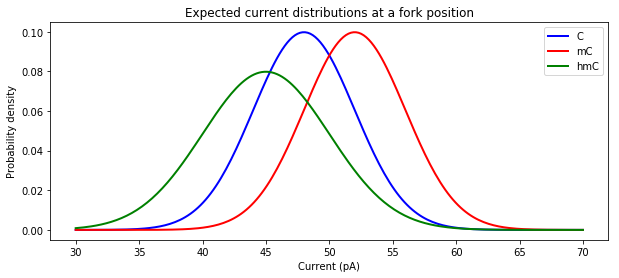

Key insight: Each modification type produces a slightly different current level.
The HMM uses these differences to classify which modification is present.


In [20]:
# Hypothetical current distributions for position where modifications matter
# (Real values come from training data)

fork_distributions = {
    'C': NormalDistribution(48, 4),     # Cytosine
    'mC': NormalDistribution(52, 4),    # Methylcytosine  
    'hmC': NormalDistribution(45, 5)    # Hydroxymethylcytosine
}

# Visualize how these distributions differ
x = np.linspace(30, 70, 200)
plt.figure(figsize=(10, 4))

colors = {'C': 'blue', 'mC': 'red', 'hmC': 'green'}
for name, dist in fork_distributions.items():
    mu, sigma = dist.parameters[0], dist.parameters[1]
    y = np.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    plt.plot(x, y, label=name, color=colors[name], linewidth=2)

plt.xlabel('Current (pA)')
plt.ylabel('Probability density')
plt.title('Expected current distributions at a fork position')
plt.legend()
plt.show()

print "Key insight: Each modification type produces a slightly different current level."
print "The HMM uses these differences to classify which modification is present."

## Part 6: How Classification Works - Forward-Backward

Given an observed sequence of current levels, the Forward-Backward algorithm calculates:
1. The probability of each possible state sequence
2. The expected number of times we transition through each path

The path (C, mC, or hmC) with the highest expected transitions = the classification.

In [21]:
# Let's trace through what happens with a real model and real data

from pypore_compat import File

# Load the pre-trained model
with open('untrained_hmm.txt', 'r') as f:
    from yahmm import Model
    model = Model.read(f)

print "Model: {}".format(model.name)
print "Total states: {}".format(len(model.states))

# Count state types
state_types = {}
for state in model.states:
    prefix = state.name.split('-')[0] if '-' in state.name else state.name.split(':')[0]
    state_types[prefix] = state_types.get(prefix, 0) + 1

print "\nState type counts:"
for prefix, count in sorted(state_types.items()):
    print "  {}: {}".format(prefix, count)

Model: EpigeneticsHMM-54
Total states: 1070

State type counts:
  D: 102
  EpigeneticsHMM: 2
  I: 103
  M: 306
  ME: 102
  MO: 102
  MS: 102
  U: 107
  b: 53
  bC: 18
  bCAT: 6
  bT: 6
  bU: 19
  bX: 6
  bhmC: 18
  bmC: 18


In [22]:
# Load some actual nanopore data
file = File.from_json('Data/14418004-s04.json')

# Get segment means for a few events
events = [[seg.mean for seg in event.segments] for event in file.events[:5]]

print "Loaded {} events".format(len(events))
print "Event lengths: {}".format([len(e) for e in events])

Loaded 5 events
Event lengths: [88, 131, 137, 99, 129]


In [23]:
# Run forward-backward on one event
event = events[0]
print "Analyzing event with {} segments".format(len(event))

# Forward-backward returns:
# - trans: expected transition counts (matrix)
# - ems: expected emission counts
trans, ems = model.forward_backward(event)

print "\nTransition matrix shape: {}".format(trans.shape)
print "Expected transitions from each state to all others"

Analyzing event with 88 segments

Transition matrix shape: (1070, 1070)
Expected transitions from each state to all others


In [24]:
# Now let's calculate classification scores like analyze_events() does

# Build state name -> index mapping
indices = {state.name: i for i, state in enumerate(model.states)}

# For each fork path (C, mC, hmC), sum expected transitions through that path
# The paper uses positions 25-33 for the first cytosine fork

scores = {}
for tag in ['C', 'mC', 'hmC']:
    # Find the match-end states for this path
    names = ["M-{}:{}-end".format(tag, i) for i in xrange(25, 34)]
    
    # Get minimum expected transitions (bottleneck = how much flow went through)
    min_trans = float('inf')
    for name in names:
        if name in indices:
            # Sum all transitions INTO this state
            total = trans[indices[name]].sum()
            if total < min_trans:
                min_trans = total
    
    scores[tag] = min_trans if min_trans != float('inf') else 0

print "Expected transitions through each path:"
for tag, score in sorted(scores.items(), key=lambda x: -x[1]):
    print "  {}: {:.4f}".format(tag, score)

total = sum(scores.values())
if total > 0:
    print "\nNormalized probabilities:"
    for tag in ['C', 'mC', 'hmC']:
        print "  {}: {:.1%}".format(tag, scores[tag] / total)
    
    winner = max(scores.items(), key=lambda x: x[1])
    print "\nClassification: {} (confidence: {:.1%})".format(winner[0], winner[1] / total)

Expected transitions through each path:
  C: 0.9981
  mC: 0.0000
  hmC: 0.0000

Normalized probabilities:
  C: 100.0%
  mC: 0.0%
  hmC: 0.0%

Classification: C (confidence: 100.0%)


## Part 7: The Filter Score

Not all events are equally informative. Some might:
- Not traverse the full sequence
- Get stuck in artifact states
- Have too much noise

The **Filter Score** measures how confidently the event went through the expected path.

In [25]:
def calculate_filter_score(trans, indices):
    """
    Filter score = (flow through cytosine fork) * (flow through label fork)
    
    High score = event clearly went through both forks
    Low score = event may have taken shortcuts or gotten lost
    """
    # Cytosine fork flow (positions 25-33)
    cyt_scores = {}
    for tag in ['C', 'mC', 'hmC']:
        names = ["M-{}:{}-end".format(tag, i) for i in xrange(25, 34)]
        flow = min(trans[indices[name]].sum() for name in names if name in indices)
        cyt_scores[tag] = flow
    
    # Label fork flow (positions 37-42)  
    label_scores = {}
    for tag in ['X', 'T', 'CAT']:
        names = ["M-{}:{}-end".format(tag, i) for i in xrange(37, 43)]
        matching = [name for name in names if name in indices]
        if matching:
            flow = min(trans[indices[name]].sum() for name in matching)
            label_scores[tag] = flow
        else:
            label_scores[tag] = 0
    
    cyt_total = sum(cyt_scores.values())
    label_total = sum(label_scores.values())
    
    return cyt_total * label_total, cyt_scores, label_scores

filter_score, cyt, label = calculate_filter_score(trans, indices)
print "Filter Score: {:.4f}".format(filter_score)
print "\nCytosine fork: {}".format(cyt)
print "Label fork: {}".format(label)

Filter Score: 0.9981

Cytosine fork: {'C': 0.9981393879543726, 'mC': 1.9733785724828583e-08, 'hmC': 9.620678249290519e-09}
Label fork: {'X': 1.8462225001523376e-65, 'T': 0.9999474700614138, 'CAT': 5.668096336559426e-15}


In [26]:
# Analyze multiple events and see the distribution of filter scores
from pypore_compat import File

# Load more data
file = File.from_json('Data/14418004-s04.json')
all_events = [[seg.mean for seg in event.segments] for event in file.events]

print "Analyzing {} events...".format(len(all_events))

filter_scores = []
classifications = []

for event in all_events:
    trans, ems = model.forward_backward(event)
    fs, cyt, label = calculate_filter_score(trans, indices)
    filter_scores.append(fs)
    
    # Classify
    if sum(cyt.values()) > 0:
        winner = max(cyt.items(), key=lambda x: x[1])[0]
        classifications.append(winner)
    else:
        classifications.append('unknown')

print "Done!"

Analyzing 47 events...
Done!


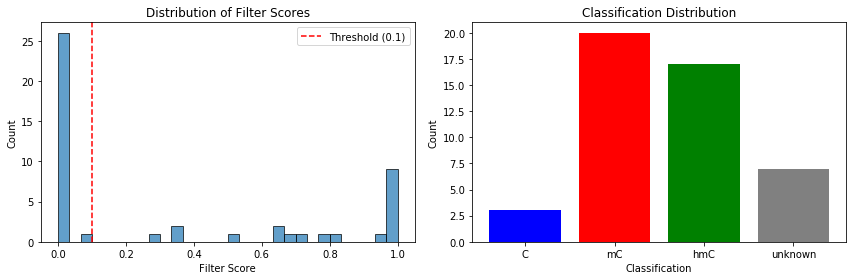


Events above threshold (0.1): 20/47


In [27]:
# Visualize filter score distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(filter_scores, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Filter Score')
plt.ylabel('Count')
plt.title('Distribution of Filter Scores')
plt.axvline(x=0.1, color='r', linestyle='--', label='Threshold (0.1)')
plt.legend()

plt.subplot(1, 2, 2)
from collections import Counter
class_counts = Counter(classifications)
labels = ['C', 'mC', 'hmC', 'unknown']
counts = [class_counts.get(l, 0) for l in labels]
colors = ['blue', 'red', 'green', 'gray']
plt.bar(labels, counts, color=colors)
plt.xlabel('Classification')
plt.ylabel('Count')
plt.title('Classification Distribution')

plt.tight_layout()
plt.show()

print "\nEvents above threshold (0.1): {}/{}".format(
    sum(1 for fs in filter_scores if fs > 0.1), len(filter_scores))

## Part 8: Putting It Together - The Full Pipeline

1. **Raw signal** -> Segmentation -> **List of segment means**
2. **Segment means** -> Forward-Backward -> **Transition matrix**
3. **Transition matrix** -> Sum flow through forks -> **Filter Score + Classification**
4. Apply threshold -> **High-confidence classifications**

In [28]:
import pandas as pd

def analyze_events_explained(events, model):
    """
    Full analysis pipeline with detailed output.
    This is essentially what analyze_events() does.
    """
    indices = {state.name: i for i, state in enumerate(model.states)}
    
    results = []
    for idx, event in enumerate(events):
        # Step 1: Run forward-backward
        trans, ems = model.forward_backward(event)
        
        # Step 2: Calculate flow through each fork path
        d = {}
        
        # Cytosine fork (positions 25-33)
        for tag in ['C', 'mC', 'hmC']:
            names = ["M-{}:{}-end".format(tag, i) for i in xrange(25, 34)]
            matching = [name for name in names if name in indices]
            if matching:
                d[tag] = min(trans[indices[name]].sum() for name in matching)
            else:
                d[tag] = 0
        
        # Label fork (positions 37-42)
        for tag in ['X', 'T', 'CAT']:
            names = ["M-{}:{}-end".format(tag, i) for i in xrange(37, 43)]
            matching = [name for name in names if name in indices]
            if matching:
                d[tag] = min(trans[indices[name]].sum() for name in matching)
            else:
                d[tag] = 0
        
        # Step 3: Calculate filter score
        cyt_sum = d['C'] + d['mC'] + d['hmC']
        label_sum = d['X'] + d['T'] + d['CAT']
        d['Filter Score'] = cyt_sum * label_sum
        
        # Step 4: Calculate soft call (dot product score)
        # This uses the correlation: C<->T, mC<->CAT, hmC<->X
        score = d['C']*d['T'] + d['mC']*d['CAT'] + d['hmC']*d['X']
        d['Soft Call'] = score / d['Filter Score'] if d['Filter Score'] != 0 else 0
        
        # Step 5: Hard classification
        if cyt_sum > 0:
            d['Classification'] = max(['C', 'mC', 'hmC'], key=lambda k: d[k])
            d['Confidence'] = d[d['Classification']] / cyt_sum
        else:
            d['Classification'] = 'unknown'
            d['Confidence'] = 0
        
        results.append(d)
    
    return pd.DataFrame(results)

# Run on a subset
df = analyze_events_explained(all_events[:20], model)
print df[['Filter Score', 'C', 'mC', 'hmC', 'Classification', 'Confidence']].head(10)

   Filter Score              C            mC            hmC Classification  \
0  9.980870e-01   9.981394e-01  1.973379e-08   9.620678e-09              C   
1  9.999273e-01   9.999674e-01  7.021248e-07   3.348330e-06              C   
2  7.204279e-03   2.206169e-23  1.177000e-03   6.053912e-03            hmC   
3  1.951675e-20   1.601975e-39  1.012994e-13   3.782172e-20             mC   
4  7.689442e-01   5.748661e-19  7.689662e-01   8.973036e-07             mC   
5  1.206157e-73  9.346549e-226  8.253953e-70  3.255378e-118             mC   
6  3.266419e-29   1.093059e-28  3.512391e-14   2.368312e-24             mC   
7  0.000000e+00   0.000000e+00  0.000000e+00   0.000000e+00        unknown   
8  7.118764e-01   3.278361e-21  7.183948e-01   9.159700e-07             mC   
9  3.172287e-20   2.390981e-27  4.557005e-14   2.715951e-27             mC   

   Confidence  
0    1.000000  
1    0.999996  
2    0.837227  
3    1.000000  
4    0.999999  
5    1.000000  
6    1.000000  
7    0.000000

In [29]:
# Filter by score threshold and look at high-confidence classifications
threshold = 0.1
high_conf = df[df['Filter Score'] > threshold]

print "Events above threshold: {}/{}".format(len(high_conf), len(df))
print "\nClassification breakdown:"
print high_conf['Classification'].value_counts()

print "\nMean confidence by class:"
print high_conf.groupby('Classification')['Confidence'].mean()

Events above threshold: 6/20

Classification breakdown:
mC     3
C      2
hmC    1
Name: Classification, dtype: int64

Mean confidence by class:
Classification
C      0.999998
hmC    1.000000
mC     0.999999
Name: Confidence, dtype: float64


## Summary: Key Insights

1. **Modular Architecture**: Each DNA position is a circuit board with 7 ports, handling various artifacts

2. **Artifact Handling**:
   - Oversegmentation: Match model with high self-loop probability
   - Undersegmentation: U-modules with "blend" distributions
   - Backslips: Port 7 backward connections
   - Inserts/Deletes: Dedicated states with uniform emission

3. **Classification by Fork**:
   - At modification-sensitive positions, model forks into parallel paths
   - Forward-Backward calculates expected flow through each path
   - Path with highest flow = classification

4. **Quality Control**:
   - Filter Score measures confidence (flow through both forks)
   - Only events above threshold (0.1) are used for training/classification
   - Paper reports 97% accuracy on top 26% of events